## Problem 2.2 (Exploring fish sleep data)

Problem 2.2 (Exploring fish sleep data, 65 pts)
In Tutorial 2, we used a data set dealing with zerbafish sleep to learn about tidy data and split-apply-combine. It was fun to work with the data and to make some plots of fish activity over time. In this problem, you will work with your group to come up with some good ways to parametrize sleep behavior and estimate the values of these parameters.

Choose two different ways to parametrize sleep behavior. You can use sleep metrics from the Prober, et al. paper or (for more fun) invent your own. For each of the ways of parametrizing sleep, provide instructive plots and estimate the values of the parameters. Be sure to discuss the rationale behind choosing your parametrizations.

Note that there is a lot of debate among the community of scientists studying sleep how to best quantify the behavior. This is generally true in studies of behavior, and much of the process of understanding the measurements is deciding on what to use as metrics. This problem obviously has no right answer. What is important is that you can provide a clear rational for your choices.

As you work through this problem, much of what you will do is exploratory data analysis. You will work with data frames to compute the behavioral metrics of interest and make instructive plots. Again, this problem is intentionally open-ended. You are taking a data set and making plots that you might put in a presentation or in a paper to describe the behavior. As you do the analysis, provide text that discusses your choice and what conclusions you can draw from your analyses.

You do not need to do any data validation (we'll get to that next week). You can download and use the resampled data set you generated in Tutorial 2 here. If you feel that you need to use the original data set, you can get the activity file here and the genotypes file here.

In [1]:
import numpy as np
import pandas as pd
import itertools

import altair as alt
import bokeh.io

import bebi103
import altair_catplot as altcat

bokeh.io.output_notebook()

Loading BokehJS ...

Our goal for this problem is to come up with two metrics to parameterize sleep behavior. 

Let's first read in the resampled data set we generated in Tutorial 2.

In [12]:
df = pd.read_csv('../data/130315_1A_aanat2_resampled.csv', comment = '#')

# Take a look
df.head()

location                 time   activity       zeit  zeit_ind  day  \
0         1  2013-03-15 18:30:00  85.888889 -14.500000      -869    4   
1         1  2013-03-15 18:40:00   4.500000 -14.333333      -860    4   
2         1  2013-03-15 18:50:00   0.000000 -14.166667      -850    4   
3         1  2013-03-15 19:00:00   0.000000 -14.000000      -840    4   
4         1  2013-03-15 19:10:00   0.000000 -13.833333      -830    4   

  genotype  light  
0      het   True  
1      het   True  
2      het   True  
3      het   True  
4      het   True

In Prober et. al, they define a 'high active state' as more than 1 second of activity for 1 minute, and a 'low active state' as between 0 and 1 second of activity per minute. Since we have a resampled data set where the activity is summed over 10 minutes, let's define a 'high active state' as more than 10 seconds of activity in 10 minutes, a 'low active state' as between 0 and 10 seconds of activity in 10 minutes, and an 'inactive state' as 0 seconds of activity in 10 minutes.

Let's define a function that takes in the amount of activity and labels what state the fish is in.

In [13]:
def label_activity_state(df):
    '''Takes in a dataframe with an activity column and returns a string
    labeling the type of active state.'''
    if df['activity'] > 10:
        return 'high'
    if (df['activity'] <= 10) & (df['activity'] > 0):
        return 'low'
    if df['activity'] == 0:
        return 'inactive'

In [14]:
df['activity state'] = df.apply(label_activity_state, axis=1)
df.head()

location                 time   activity       zeit  zeit_ind  day  \
0         1  2013-03-15 18:30:00  85.888889 -14.500000      -869    4   
1         1  2013-03-15 18:40:00   4.500000 -14.333333      -860    4   
2         1  2013-03-15 18:50:00   0.000000 -14.166667      -850    4   
3         1  2013-03-15 19:00:00   0.000000 -14.000000      -840    4   
4         1  2013-03-15 19:10:00   0.000000 -13.833333      -830    4   

  genotype  light activity state  
0      het   True           high  
1      het   True            low  
2      het   True       inactive  
3      het   True       inactive  
4      het   True       inactive

Now let's try plotting the activity state over time for the fish in location 1.

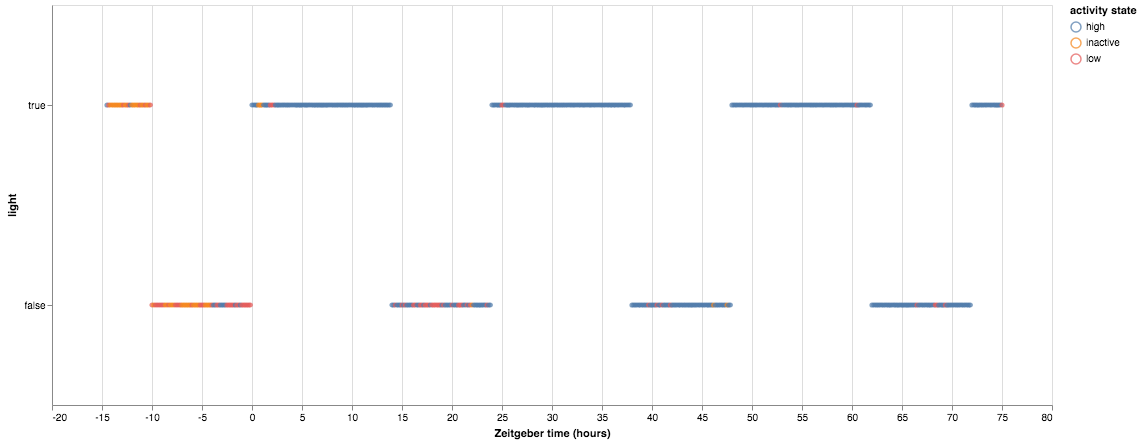

In [20]:
### should we relabel true and false as day and night?

alt.Chart(df.loc[df['location']==1, :], 
          height=400, 
          width=1000
         ).mark_point(
            size=10
         ).encode(
             x=alt.X('zeit:Q', title='Zeitgeber time (hours)'),
             y=alt.Y('light:N', sort = [True, False]),
             color ='activity state:N',
             order = 'zeit:Q'
         )       

In [10]:
df[df['location'] == 1]['genotype'].unique()

array(['het'], dtype=object)

For this heterozygous fish in location 1, the fish seems to be in the high activity state at almost all times when the lights are on. When the lights are off, this fish is still often in the high active state but there is more switching between high, inactive, and low activity states.

Now let's average the activity over all locations by genotype, so we can look at how each genotype responds to lights on and lights off.

In [16]:
# Average the activity over all locations of a given genotype
average_df = df.groupby(['genotype', 'zeit_ind']).mean().reset_index()

# location columns is irrelavant
del average_df['location']

average_df.head()

genotype  zeit_ind   activity       zeit  day  light
0      het      -869  17.921569 -14.500000  4.0   True
1      het      -860   7.900000 -14.333333  4.0   True
2      het      -850   4.891176 -14.166667  4.0   True
3      het      -840   4.041176 -14.000000  4.0   True
4      het      -830   1.411765 -13.833333  4.0   True

Relabel the activity states accordingly.

In [17]:
average_df['activity state'] = average_df.apply(label_activity_state, axis=1)

average_df.head()

genotype  zeit_ind   activity       zeit  day  light activity state
0      het      -869  17.921569 -14.500000  4.0   True           high
1      het      -860   7.900000 -14.333333  4.0   True            low
2      het      -850   4.891176 -14.166667  4.0   True            low
3      het      -840   4.041176 -14.000000  4.0   True            low
4      het      -830   1.411765 -13.833333  4.0   True            low

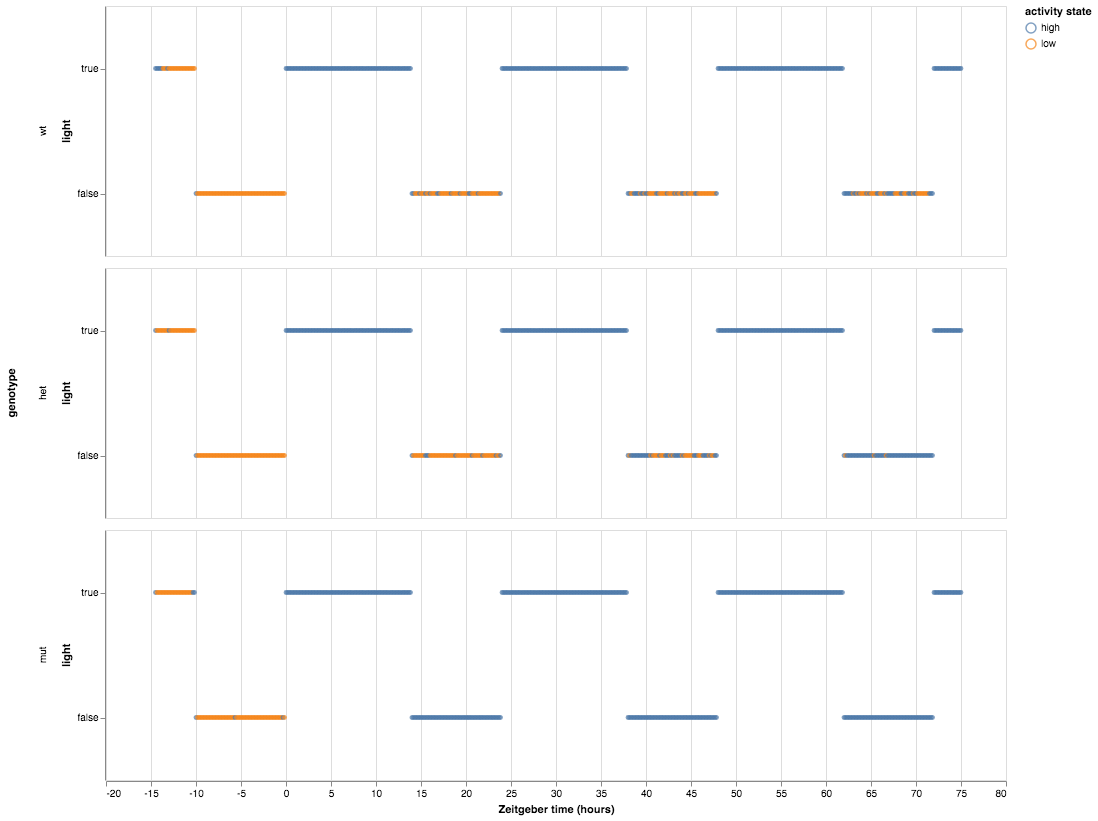

In [25]:
# plot the activity type for each genotype through light/dark cycle
alt.Chart(average_df, height=250, width=900
         ).mark_point(size=8
         ).encode(
             x=alt.X('zeit:Q', title='Zeitgeber time (hours)'),
             y=alt.Y('light:N', sort = [True, False]),
             color ='activity state:N',
             order = 'zeit:Q',
             row = alt.Row('genotype:N', sort=['wt', 'het', 'mut'])
         )

Qualitatively, we can see that when the lights are on, all genotypes spend most of their time in the high activity state. When the lights are off, the wild type is often in a low activity state and has a high frequency of changing between high and low activity states. The heterozygous also spends time in the low activity state when the lights are off, but not as much as the wild type does. The mutant seems to spend almost all of its time in the high activity state, regardless of whether the lights are on or off. 

## For the first 15 hours of the experiment, all the fish are in the low activity state in the day and in the night because...

The column 'zeit' contains the so-called Zeitgeber time in units of hours.
The Zeitgeber time is zero when the lights come on on the first day of the
experiment, which is on day 5 of the life of the fish.

#### let's remove this from our plot? or is it important to show?

### What happens when we make the threshold 20 instead?

In [27]:
def label_activity_state_2(df):
    '''Takes in a dataframe with an activity column and returns a string
    labeling the type of active state.'''
    if df['activity'] > 20:
        return 'high'
    if (df['activity'] <= 20) & (df['activity'] > 0):
        return 'low'
    if df['activity'] == 0:
        return 'inactive'

In [28]:
average_df['higher threshold activity state'] = average_df.apply(label_activity_state_2, axis=1)

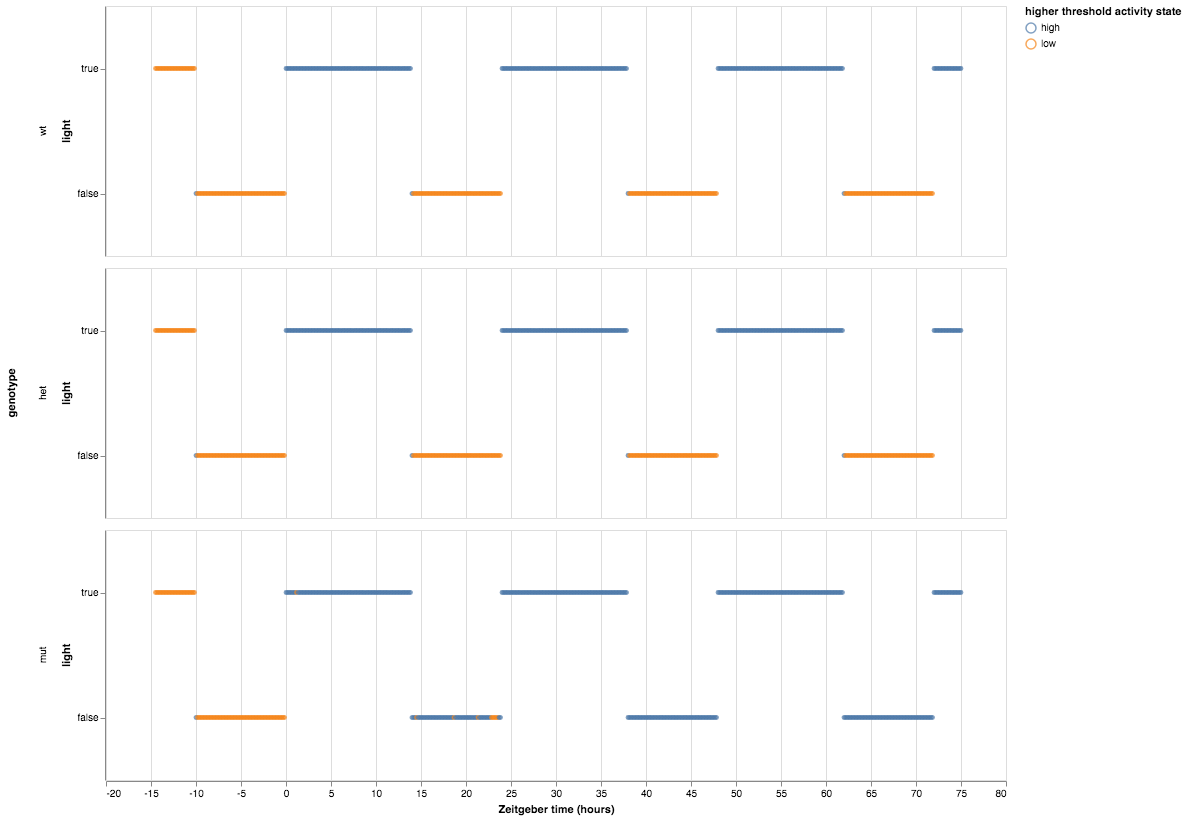

In [32]:
# plot the activity type for each genotype through light/dark cycle
alt.Chart(average_df, height=250, width=900
         ).mark_point(size=8
         ).encode(
             x=alt.X('zeit:Q', title='Zeitgeber time (hours)'),
             y=alt.Y('light:N', sort = [True, False]),
             color ='higher threshold activity state:N',
             order = 'zeit:Q',
             row = alt.Row('genotype:N', sort=['wt', 'het', 'mut'])
         )

The difference between the wild type and heterozygous is less pronounced, but the difference between the wild type and mutant is still clear.

Let's plot the activity traces over the course of the experiment by genotype.

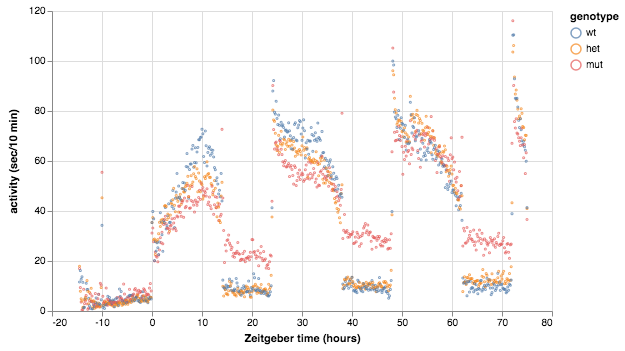

In [76]:
alt.Chart(average_df,
          height=300,
          width=500
    ).mark_point(
        size=1
    ).encode(
        x=alt.X('zeit:Q', title='Zeitgeber time (hours)'),
        y=alt.Y('activity:Q', title='activity (sec/10 min)'),
        color=alt.Color('genotype:N', sort=['wt', 'het', 'mut']),
        order='zeit:Q'
    )

### add tooltips above

We can again see that the mutant's average activity when the light is off is higher than either the wild type or the heterozygote.

In [68]:
def plot_trace(df, col='activity', genotype='wt', units='sec/10 min'):
    """Plot a trace, coloring by activity state."""
    charts = []
    for day, state in itertools.product(df['day'].unique(), 
                                       df['higher threshold activity state'].unique()):
        inds = ( (df['genotype'] == genotype) 
                & (df['day'] == day) 
                & (df['higher threshold activity state'] == state))

        charts.append(
            alt.Chart(df.loc[inds, ['zeit', col, 'higher threshold activity state']],
                  height=300,
                  width=500
                ).mark_point(
                  size=4
                ).encode(
                    x=alt.X('zeit:Q', title='Zeitgeber time (hours)'),
                    y=alt.Y(f'{col}:Q'),
                    color='higher threshold activity state:N',
                    order='zeit:Q'
            )
        )

    return alt.layer(*charts)

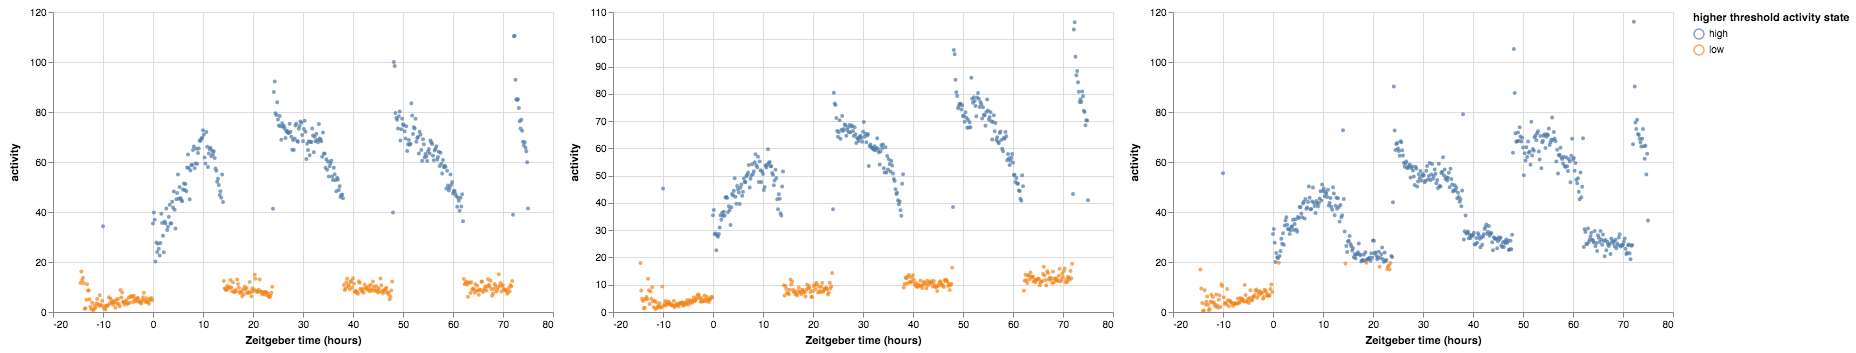

In [69]:
p1 = plot_trace(average_df, 'activity', 'wt')
p2 = plot_trace(average_df, 'activity', 'het')
p3 = plot_trace(average_df, 'activity', 'mut')

p1 | p2 | p3

Let's plot the ECDF of the activity during light and day by genotype.

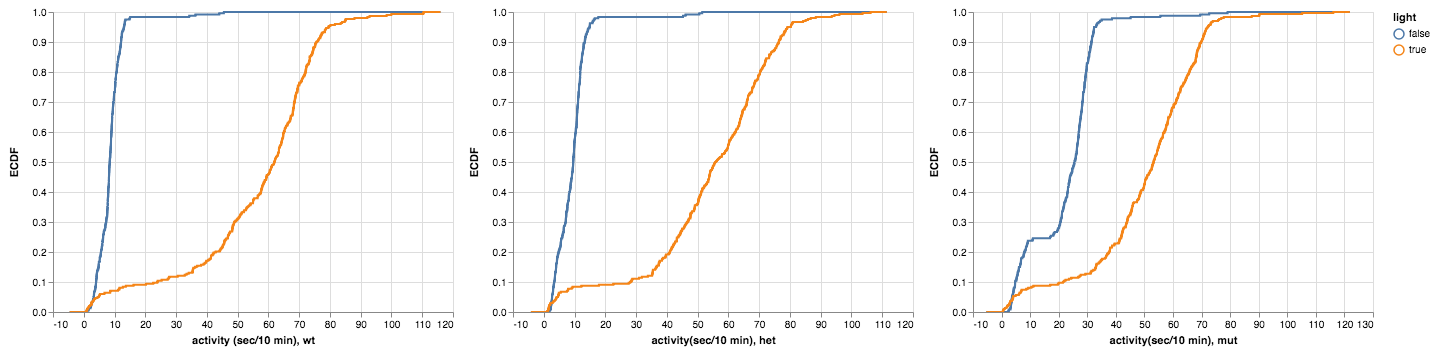

In [40]:
p1 = altcat.catplot(data=average_df.loc[average_df['genotype']=='wt', :],
               mark='line',
               encoding=dict(x = alt.X('activity:Q', title='activity (sec/10 min), wt'),
                             color = alt.Color('light:N')),
               transform = 'ecdf')

p2 = altcat.catplot(data=average_df.loc[average_df['genotype']=='het', :],
               mark='line',
               encoding=dict(x = alt.X('activity:Q', title='activity(sec/10 min), het'),
                             color = alt.Color('light:N')),
               transform = 'ecdf')

p3 = altcat.catplot(data=average_df.loc[average_df['genotype']=='mut', :],
               mark='line',
               encoding=dict(x = alt.X('activity:Q', title='activity(sec/10 min), mut'),
                             color = alt.Color('light:N')),
               transform = 'ecdf')

p1 | p2 | p3

In [86]:
# define a function that use the condion of activity to generate a new column

def label_activity_n(c):
    if c['type'] == 'high':
        return 100
    if c['type'] == 'low':
        return 0
    if c['type'] == 'in':
        return 0
    
average_df['type_n'] = average_df.apply(label_activity_n, axis = 1)
average_df.head()

genotype  zeit_ind   activity       zeit  day  light  type  type_n  \
0      het      -869  17.921569 -14.500000  4.0   True  high     100   
1      het      -860   7.900000 -14.333333  4.0   True   low       0   
2      het      -850   4.891176 -14.166667  4.0   True   low       0   
3      het      -840   4.041176 -14.000000  4.0   True   low       0   
4      het      -830   1.411765 -13.833333  4.0   True   low       0   

   rolling type  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN

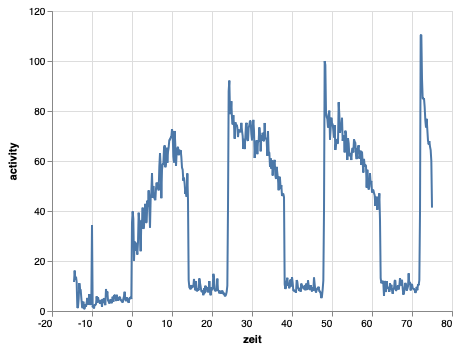

In [110]:
inds1 = average_df['genotype'] == 'wt'

alt.Chart(average_df.loc[inds1,:]
         ).mark_line(
            strokeJoin = 'bevel'
         ).encode(
            x = alt.X('zeit:Q'),
            y = 'activity:Q',
            order = 'zeit:Q',
            
         ) 

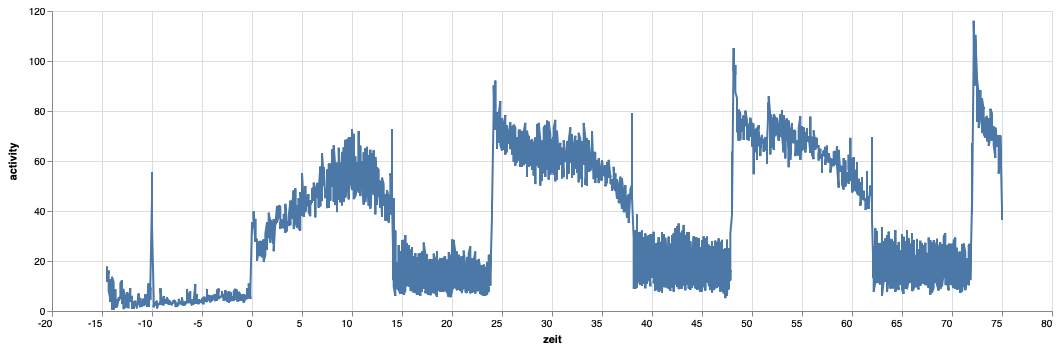

In [126]:
alt.Chart(average_df, width = 1000
         ).mark_line(
            strokeJoin = 'bevel'
         ).encode(
            x = alt.X('zeit:Q'),
            y = 'activity:Q',
            order = 'zeit:Q',
            
         ) 

In [21]:
average_df.head()

genotype  zeit_ind   activity       zeit  day  light  type
0      het      -869  17.921569 -14.500000  4.0   True  high
1      het      -860   7.900000 -14.333333  4.0   True   low
2      het      -850   4.891176 -14.166667  4.0   True   low
3      het      -840   4.041176 -14.000000  4.0   True   low
4      het      -830   1.411765 -13.833333  4.0   True   low

In [34]:
average_df['type'].unique()

array(['high', 'low'], dtype=object)

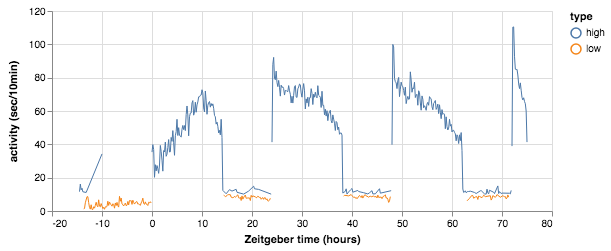

In [25]:
def plot_trace(df, col='activity', genotype='wt', units='sec/min'):
    """Plot a trace, coloring by light."""
    charts = []
    for day, act_type in itertools.product(df['day'].unique(), 
                                        df['type'].unique()):
        inds = ( (df['genotype'] == genotype) 
                & (df['day'] == day) 
                & (df['type'] == act_type))

        charts.append(
            alt.Chart(df.loc[inds, ['zeit', col, 'type']],
                  height=200,
                  width=500
                ).mark_line(
                    strokeWidth=1,
                    strokeJoin='bevel'
                ).encode(
                    x=alt.X('zeit:Q', title='Zeitgeber time (hours)'),
                    y=alt.Y(f'{col}:Q', title=f'activity ({units})'),
                    color='type:N',
                    order='zeit:Q'
            )
        )

    return alt.layer(*charts)

plot_trace(average_df, units='sec/10 min')

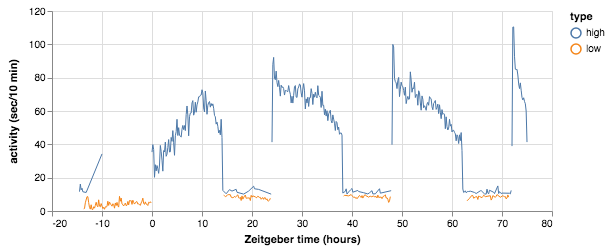

In [22]:
def plot_trace_type(c, col='activity', units='sec/min'):
    """Plot a trace, coloring by activitytype."""
    charts = []
    for day, typ in itertools.product(c['day'].unique(), 
                                        c['type'].unique()):
        inds = ( (c['genotype'] == 'wt') 
                & (c['day'] == day) 
                & (c['type'] == typ))

        charts.append(
            alt.Chart(c.loc[inds, ['zeit', col, 'type']],
                  height=200,
                  width=500
                ).mark_line(
                    strokeWidth=1,
                    strokeJoin='bevel'
                ).encode(
                    x=alt.X('zeit:Q', title='Zeitgeber time (hours)'),
                    y=alt.Y(f'{col}:Q', title=f'activity ({units})'),
                    color='type:N',
                    order='zeit:Q'
            )
        )

    return alt.layer(*charts)

plot_trace_type(average_df, col='activity', units='sec/10 min')

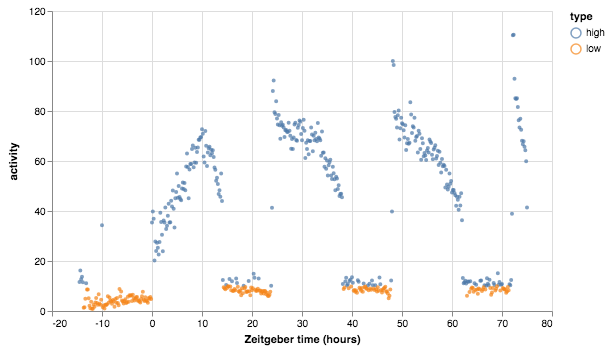

In [61]:
def plot_trace_type(c, col='activity', genotype='wt', units='sec/min'):
    """Plot a trace, coloring by activitytype."""
    charts = []
    for day, type in itertools.product(c['day'].unique(), 
                                        c['type'].unique()):
        inds = ( (c['genotype'] == genotype) 
                & (c['day'] == day) 
                & (c['type'] == type))

        charts.append(
            alt.Chart(c.loc[inds, ['zeit', col, 'type']],
                  height=300,
                  width=500
                ).mark_point(size =4,
#                              opacity=0.6
                ).encode(
                    x=alt.X('zeit:Q', title='Zeitgeber time (hours)'),
                    y=alt.Y(f'{col}:Q'),
                    color='type:N',
                    order='zeit:Q'
            )
        )

    return alt.layer(*charts)

plot_trace_type(average_df, col='activity', units='sec/10 min')

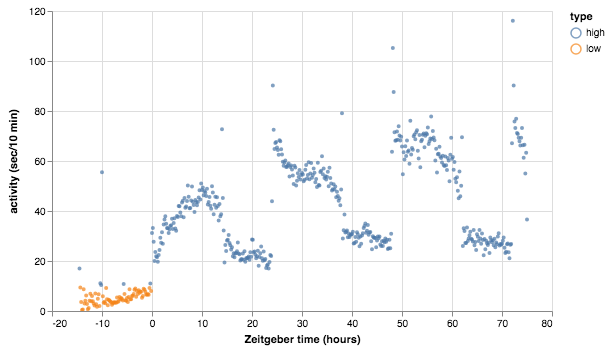

In [32]:
plot_trace_type(average_df, genotype='mut', units='sec/10 min')

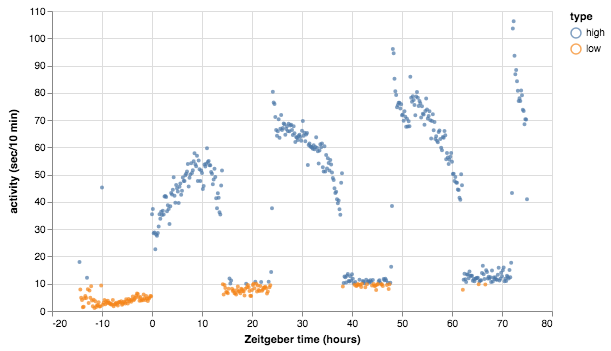

In [33]:
plot_trace_type(average_df, genotype='het', units='sec/10 min')

### Percentage of time in particular state

In [44]:
average_df

genotype  zeit_ind    activity       zeit  day  light  type
0         het      -869   17.921569 -14.500000  4.0   True  high
1         het      -860    7.900000 -14.333333  4.0   True   low
2         het      -850    4.891176 -14.166667  4.0   True   low
3         het      -840    4.041176 -14.000000  4.0   True   low
4         het      -830    1.411765 -13.833333  4.0   True   low
5         het      -820    1.576471 -13.666667  4.0   True   low
6         het      -810    4.629412 -13.500000  4.0   True   low
7         het      -800    5.520588 -13.333333  4.0   True   low
8         het      -790    4.723529 -13.166667  4.0   True   low
9         het      -780   12.226471 -13.000000  4.0   True  high
10        het      -770    7.932353 -12.833333  4.0   True   low
11        het      -760    2.908824 -12.666667  4.0   True   low
12        het      -750    7.526471 -12.500000  4.0   True   low
13        het      -740    4.835294 -12.333333  4.0   True   low
14        het      -730    9.082353 -12.166667  4.0   True   low
15        het      -720    3.861765 -12.000000  4.0   True   low
16        het      -710    1.747059 -11.833333  4.0   True   low
17        het      -700    4.144118 -11.666667  4.0   True   low
18        het      -690    1.073529 -11.500000  4.0   True   low
19        het      -680    3.570588 -11.333333  4.0   True   low
20        het      -670    1.502941 -11.166667  4.0   True   low
21        het      -660    2.120588 -11.000000  4.0   True   low
22        het      -650    2.105882 -10.833333  4.0   True   low
23        het      -640    3.194118 -10.666667  4.0   True   low
24        het      -630    1.614706 -10.500000  4.0   True   low
25        het      -620    1.700000 -10.333333  4.0   True   low
26        het      -610    9.370588 -10.166667  4.0   True   low
27        het      -600   45.252941 -10.000000  4.0  False  high
28        het      -590    2.291176  -9.833333  4.0  False   low
29        het      -580    3.000000  -9.666667  4.0  False   low
...       ...       ...         ...        ...  ...    ...   ...
1584       wt      4210    9.194118  70.166667  7.0  False   low
1585       wt      4220    8.852941  70.333333  7.0  False   low
1586       wt      4230    8.605882  70.500000  7.0  False   low
1587       wt      4240    8.694118  70.666667  7.0  False   low
1588       wt      4250    7.264706  70.833333  7.0  False   low
1589       wt      4260    7.794118  71.000000  7.0  False   low
1590       wt      4270    9.647059  71.166667  7.0  False   low
1591       wt      4280    8.311765  71.333333  7.0  False   low
1592       wt      4290   10.652941  71.500000  7.0  False  high
1593       wt      4300   10.276471  71.666667  7.0  False  high
1594       wt      4310   12.352941  71.833333  7.0  False  high
1595       wt      4320   38.941176  72.000000  8.0   True  high
1596       wt      4330  110.335294  72.166667  8.0   True  high
1597       wt      4340  110.452941  72.333333  8.0   True  high
1598       wt      4350   92.882353  72.500000  8.0   True  high
1599       wt      4360   85.105882  72.666667  8.0   True  high
1600       wt      4370   84.829412  72.833333  8.0   True  high
1601       wt      4380   85.052941  73.000000  8.0   True  high
1602       wt      4390   81.617647  73.166667  8.0   True  high
1603       wt      4400   76.252941  73.333333  8.0   True  high
1604       wt      4410   73.447059  73.500000  8.0   True  high
1605       wt      4420   76.876471  73.666667  8.0   True  high
1606       wt      4430   72.476471  73.833333  8.0   True  high
1607       wt      4440   68.105882  74.000000  8.0   True  high
1608       wt      4450   66.658824  74.166667  8.0   True  high
1609       wt      4460   67.947059  74.333333  8.0   True  high
1610       wt      4470   65.747059  74.500000  8.0   True  high
1611       wt      4480   64.347059  74.666667  8.0   True  high
1612       wt      4490   59.941176  74.833333  8.0   True  high
1613       wt      4500   41.352941  75.

In [87]:
grouped = average_df.groupby('genotype')['zeit_ind', 'type_n']

rolling = grouped.rolling(window=6, on='zeit_ind')

rolling

RollingGroupby [window=6,center=False,axis=0,on=zeit_ind]

In [88]:
df_rolling = rolling.mean()

# Take a look
df_rolling.head(n=10)

zeit_ind     type_n
genotype                       
het      0      -869        NaN
         1      -860        NaN
         2      -850        NaN
         3      -840        NaN
         4      -830        NaN
         5      -820  16.666667
         6      -810   0.000000
         7      -800   0.000000
         8      -790   0.000000
         9      -780  16.666667

In [89]:
df_rolling = df_rolling.reset_index(level=0)

In [90]:
df_rolling.head(n=20)

genotype  zeit_ind     type_n
0       het      -869        NaN
1       het      -860        NaN
2       het      -850        NaN
3       het      -840        NaN
4       het      -830        NaN
5       het      -820  16.666667
6       het      -810   0.000000
7       het      -800   0.000000
8       het      -790   0.000000
9       het      -780  16.666667
10      het      -770  16.666667
11      het      -760  16.666667
12      het      -750  16.666667
13      het      -740  16.666667
14      het      -730  16.666667
15      het      -720   0.000000
16      het      -710   0.000000
17      het      -700   0.000000
18      het      -690   0.000000
19      het      -680   0.000000

In [91]:
average_df['rolling type'] = df_rolling['type_n']

average_df.head(n=20)

genotype  zeit_ind   activity       zeit  day  light  type  type_n  \
0       het      -869  17.921569 -14.500000  4.0   True  high     100   
1       het      -860   7.900000 -14.333333  4.0   True   low       0   
2       het      -850   4.891176 -14.166667  4.0   True   low       0   
3       het      -840   4.041176 -14.000000  4.0   True   low       0   
4       het      -830   1.411765 -13.833333  4.0   True   low       0   
5       het      -820   1.576471 -13.666667  4.0   True   low       0   
6       het      -810   4.629412 -13.500000  4.0   True   low       0   
7       het      -800   5.520588 -13.333333  4.0   True   low       0   
8       het      -790   4.723529 -13.166667  4.0   True   low       0   
9       het      -780  12.226471 -13.000000  4.0   True  high     100   
10      het      -770   7.932353 -12.833333  4.0   True   low       0   
11      het      -760   2.908824 -12.666667  4.0   True   low       0   
12      het      -750   7.526471 -12.500000  4.0   True   low       0   
13      het      -740   4.835294 -12.333333  4.0   True   low       0   
14      het      -730   9.082353 -12.166667  4.0   True   low       0   
15      het      -720   3.861765 -12.000000  4.0   True   low       0   
16      het      -710   1.747059 -11.833333  4.0   True   low       0   
17      het      -700   4.144118 -11.666667  4.0   True   low       0   
18      het      -690   1.073529 -11.500000  4.0   True   low       0   
19      het      -680   3.570588 -11.333333  4.0   True   low       0   

    rolling type  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN  
5      16.666667  
6       0.000000  
7       0.000000  
8       0.000000  
9      16.666667  
10     16.666667  
11     16.666667  
12     16.666667  
13     16.666667  
14     16.666667  
15      0.000000  
16      0.000000  
17      0.000000  
18      0.000000  
19      0.000000

In [92]:
average_df.head()

genotype  zeit_ind   activity       zeit  day  light  type  type_n  \
0      het      -869  17.921569 -14.500000  4.0   True  high     100   
1      het      -860   7.900000 -14.333333  4.0   True   low       0   
2      het      -850   4.891176 -14.166667  4.0   True   low       0   
3      het      -840   4.041176 -14.000000  4.0   True   low       0   
4      het      -830   1.411765 -13.833333  4.0   True   low       0   

   rolling type  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN

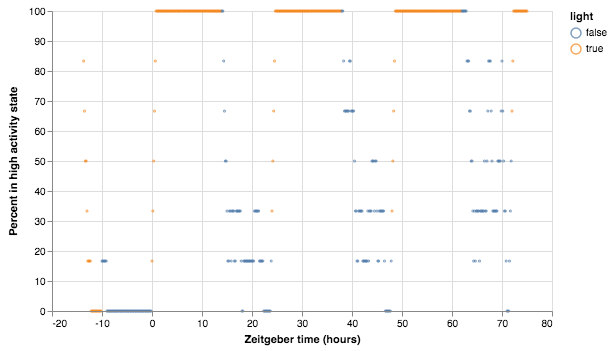

In [93]:
def plot_trace_type(df, col, genotype='wt', units='sec/min'):
    """Plot a trace, coloring by light."""
    charts = []
    for day, light in itertools.product(df['day'].unique(), 
                                        df['light'].unique()):
        inds = ( (df['genotype'] == genotype) 
                & (df['day'] == day) 
                & (df['light'] == light))

        charts.append(
            alt.Chart(df.loc[inds, ['zeit', col, 'light']],
                  height=300,
                  width=500
                ).mark_point(size=1
                ).encode(
                    x=alt.X('zeit:Q', title='Zeitgeber time (hours)'),
                    y=alt.Y(f'{col}:Q', title="Percent in high activity state"),
                    color='light:N',
                    order='zeit:Q'
            )
        )

    return alt.layer(*charts)

plot_trace_type(average_df, 'rolling type')

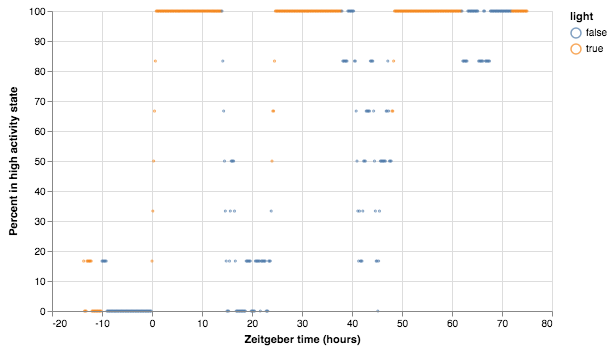

In [94]:
plot_trace_type(average_df, 'rolling type', genotype='het')

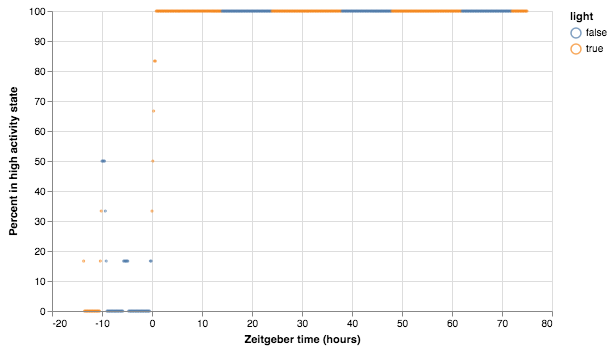

In [95]:
plot_trace_type(average_df, 'rolling type', genotype='mut')

### Frequency of change